In [1]:
%load_ext autoreload
%autoreload 2

I will try get explanations to the squared loss by modifying the default shap code through my local fork:

- Fork the shap package
- clone it from GitHub
- create a new conda environment
- install the package in editable mode

this works:

In [2]:
from shap.explainers import _tree

imported from folder


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Structure of the treeExplainer

- \_init\_(): 
  - creates a treeExplainer object:
  - self.model = TreeEnsemble (custom class):
    - attribute self.model_output, set to "raw" for RFR
    - attribute self.objective
    - method get_transform() -> this links to custom C++ classes. Here by default the RFR gets "identity". We want "squared_loss"
- shap_values():
  - gets transform = self.model.get_transform()
  - passes to c function _cext.dense_tree_shap(..., transform)

-> Initialising the get_transform() to "squared_loss" should do the trick?

For details of the changes I made to the shap package, check out the fork.



In [3]:
# build a toy model
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_diabetes

# Load the Diabetes dataset
diabetes = load_diabetes()

# create data
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

# train a random forest model
model = RandomForestRegressor(n_estimators=50, max_depth=2, random_state=0)
model.fit(X, y)
model.score(X, y)


0.4911965468843005

In [4]:
tE = _tree.TreeExplainer(model, data = X, model_output="squared_loss", feature_perturbation="interventional")

In [5]:
tE.model_output

'squared_loss'

I change the source code to override the transform argument that will be passed to the c function for shap computation.

In [6]:
tE.model.get_transform()

'squared_loss'

Let's try compute the shap values for this loss:

In [7]:
print(X.shape)

(442, 10)


In [9]:
tE.expected_value

26485.97396824045

In [11]:
model.predict(X).mean()**2

23167.55646157506

... not sure if this is the right ballpark...

In [13]:
# get reference value (mean prediction of model)

sv = tE.shap_values(X, y=y)
sv.shape

(442, 10)

So the code is running. Let's check if I get what I want. For this purpose I construct a super simple tree.

In [14]:
[1]*10 + [2]*10

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [15]:
from sklearn.tree import DecisionTreeRegressor

x1 = [0]*10 + [1.0]*10
x2 = [1.0,0]*10
data = pd.DataFrame({"x1":x1, "x2":x2})
data["y"] = data.x1 + data.x2

data.head(20)

,x1,x2,y
0,0.0,1.0,1.0
1,0.0,0.0,0.0
2,0.0,1.0,1.0
3,0.0,0.0,0.0
4,0.0,1.0,1.0
5,0.0,0.0,0.0
6,0.0,1.0,1.0
7,0.0,0.0,0.0
8,0.0,1.0,1.0
9,0.0,0.0,0.0


In [16]:
# train Decision Tree with depth = 2
X = data[["x1", "x2"]]
y = data.y

simple_tree = DecisionTreeRegressor(max_depth=2)
simple_tree.fit(X = X, y = y)

simple_tree.score(X = X, y = y)

1.0

[Text(0.5, 0.8333333333333334, 'x2 <= 0.5\nsquared_error = 0.5\nsamples = 20\nvalue = 1.0'),
 Text(0.25, 0.5, 'x1 <= 0.5\nsquared_error = 0.25\nsamples = 10\nvalue = 0.5'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 0.0'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 1.0'),
 Text(0.75, 0.5, 'x1 <= 0.5\nsquared_error = 0.25\nsamples = 10\nvalue = 1.5'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 1.0'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.0\nsamples = 5\nvalue = 2.0')]

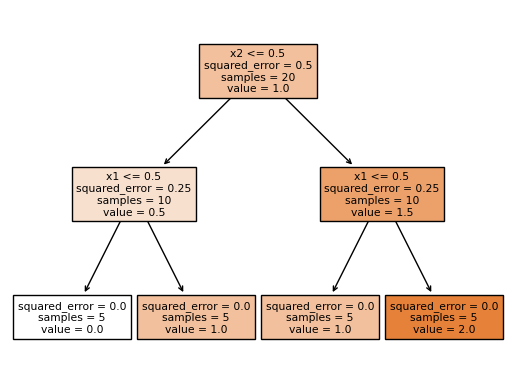

In [17]:
# visualize the tree

from sklearn.tree import plot_tree

plot_tree(simple_tree, feature_names=["x1", "x2"], filled=True)


Let's first initalize a TreeExplainer for the purpose of **prediction explanation**:

In [18]:
simple_tE = _tree.TreeExplainer(simple_tree, data = X, model_output="raw", feature_perturbation="interventional")

In [19]:
simple_tE.model.get_transform()

'identity'

In [20]:
prediction_sv = simple_tE.shap_values(data[["x1", "x2"]])
prediction_sv.shape

(20, 2)

In [21]:
prediction_sv

array([[-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [-0.5,  0.5],
       [-0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5],
       [ 0.5,  0.5],
       [ 0.5, -0.5]])

This all works correctly also in my modified shap code. Let's now try to compute the shap values for the squared deviation from the mean prediction:

In [28]:
simple_tE_dev = _tree.TreeExplainer(simple_tree, data = X, model_output="squared_loss", feature_perturbation="interventional")

imported from folder


In [30]:
simple_tE_dev.expected_value()

TypeError: TreeExplainer.__dynamic_expected_value() missing 1 required positional argument: 'y'

In [23]:
simple_tE_dev.model.get_transform()

'squared_loss'

To compute the deviations, we need to pass our reference value in a vectorized fashion to the y argument:

In [42]:
((data.y - data.y.mean())**2).mean()

0.5

In [34]:
# get reference vector
import numpy as np

ref = np.array([0.5]*20)

In [35]:
dev_sv = simple_tE_dev.shap_values(data[["x1", "x2"]], y=ref)
dev_sv.shape

(20, 2)

In [36]:
dev_sv

array([[-0.75,  0.25],
       [-0.25, -0.25],
       [-0.75,  0.25],
       [-0.25, -0.25],
       [-0.75,  0.25],
       [-0.25, -0.25],
       [-0.75,  0.25],
       [-0.25, -0.25],
       [-0.75,  0.25],
       [-0.25, -0.25],
       [ 0.75,  0.75],
       [ 0.25, -0.75],
       [ 0.75,  0.75],
       [ 0.25, -0.75],
       [ 0.75,  0.75],
       [ 0.25, -0.75],
       [ 0.75,  0.75],
       [ 0.25, -0.75],
       [ 0.75,  0.75],
       [ 0.25, -0.75]])

In [39]:
data.head(20)

,x1,x2,y
0,0.0,1.0,1.0
1,0.0,0.0,0.0
2,0.0,1.0,1.0
3,0.0,0.0,0.0
4,0.0,1.0,1.0
5,0.0,0.0,0.0
6,0.0,1.0,1.0
7,0.0,0.0,0.0
8,0.0,1.0,1.0
9,0.0,0.0,0.0


In [38]:
simple_tE_dev.expected_value(ref)

0.75

### OLD

The code runs! However, I am not sure if these values are what I want - one needs to be aware that the computed shap values here are the deviation from the "baseline". I am not sure how this is computed for a loss... I will need to check this, so come back to this later.

Let's try to by using the square expansion:

In [ ]:
def get_squared_loss_shap_from_shap_values(model, X, y):
    tE = _tree.TreeExplainer(model, X, feature_perturbation="tree_path_dependent")
    identity_shap = tE.shap_values(X,y, check_additivity=True, custom_transform = "identity")
    squared_shap = tE.shap_values(X, y, check_additivity=False, custom_transform = "square")
    # compute row wise transformation: y vector is subtracted and multiplied row wise!
    squared_loss_shap = (y**2)[:, np.newaxis] - 2*(y[:, np.newaxis]*identity_shap) + squared_shap
    return squared_loss_shap

sl_shap = get_squared_loss_shap_from_shap_values(model, X, y)

In [ ]:
sl_shap.shape

(442, 10)

In [ ]:
sl_shap.sum(axis=1)

array([ 211344.992775  ,   64938.89463125,  189397.36990498,
        421013.02260472,  197690.57136623,  105344.74271027,
        206476.55049391,   46348.3858545 ,  117751.13272823,
        937504.96739907,  113731.26054282,   47762.37100432,
        340901.76199905,  338456.6977766 ,  152728.97498537,
        286950.87790477,  258514.34484023,  198900.87787619,
        104981.84270792,  298173.59598763,   53858.64645372,
         29666.52871967,   53910.33544337,  566412.33904604,
        334461.51536332,  407912.52902697,  203609.92103577,
         68217.14922094,  178826.40359236,  790722.38070709,
        164035.46414555,   41632.82330105, 1119200.06837586,
         85453.1543444 ,   49772.60004987,  103733.36264967,
        676527.47144823,  750319.11534856,  598277.3496452 ,
         76335.459807  ,  101516.7271275 ,   36606.3054685 ,
         43766.28025364,   95311.59541958,  642711.51084037,
         33895.86330604,  377905.96690359,  217610.94034373,
         64938.89463125,

In [ ]:
# get df with prediction, output, prediction error squared, and sum of shap values
df = pd.DataFrame({"prediction": model.predict(X), "output": y, "prediction_error_squared": (model.predict(X) - y)**2, "sum_shap_manual": sl_shap.sum(axis=1), "sum_shap_squared_error" : tE.shap_values(X,y, check_additivity=False, custom_transform="squared_loss").sum(axis=1)})
df.sample(10)

,prediction,output,prediction_error_squared,sum_shap_manual,sum_shap_squared_error
136,98.348188,85.0,178.174133,82105.189213,-6911.341961
279,100.228499,200.0,9954.352356,422517.332852,6114.535172
312,98.348188,144.0,2084.087904,224096.327243,-34.224215
311,193.029316,180.0,169.763084,310944.462809,-2332.046216
185,166.164374,101.0,4246.395673,100100.207181,-804.686880
354,217.852365,272.0,2931.966411,706614.130160,-12333.289307
133,98.348188,83.0,235.566887,78511.930296,-7144.464596
249,213.522198,215.0,2.183898,437857.368488,-5359.907870
409,167.833418,181.0,173.358888,323577.449396,-2377.051142
34,98.348188,65.0,1112.101669,49772.600050,-9242.568315


Maybe the latter can be fixed - could it be that this is an offset problem?

Also, notice how somehow this works if you do not add y to the method but it computes something else? Whats going on...

In [ ]:
tE.shap_values(X,y, check_additivity=False, custom_transform="squared_loss").sum(axis=1)

array([  1737.82920945,  -8076.95513789,    216.73086749,  -2697.15928587,
        -1149.46874026,  -5512.60614783,   -733.59212091,  -9093.19026306,
         -348.5864217 , -12165.56046038,  -5046.36087733,  -2144.66308467,
         3898.72370935,  -2435.34959983,  -3099.9067312 ,  -2160.02630765,
         -265.40513405,   -339.77665233,  -5503.93647544,   1381.45544473,
        -8775.15664927, -11107.54939759,  -8799.70251172,  -9397.62353104,
        -2444.1827462 ,  -1988.49776829,   -850.15343863,   2038.4889583 ,
        -2610.67261943,  -6188.05608721,  -1358.09201598,  -9941.93622157,
       -21475.5276086 ,  -6631.94343172,  -9242.56831519,  -1785.641031  ,
       -10133.93294529,  -6488.92099359, -10554.9282848 ,   2201.97929775,
        -2758.88699916, -10408.18149249,  -9383.07057025,  -6095.41273423,
       -10131.99307632, -10358.10102757,   3003.25349475,   -427.90517333,
        -8076.95513819,   -465.50453593,    876.76426091,  -5380.99595411,
        -9790.36290803,  

In [ ]:
tE.shap_values(X, check_additivity=False, custom_transform="squared_loss").sum(axis=1)

array([ 18468.49102782, -16819.05396764,   9672.46550728,    671.9982456 ,
       -16638.24102704, -16819.05396764, -16819.05396764, -15800.55035737,
         2922.61122601,  11388.55138042, -16819.05396758,  -2293.44458028,
       -16638.24102604,   1380.83823753, -16638.24102604,   3326.7569697 ,
        16843.05872967,   8158.63174563, -16445.60394811, -14588.25602988,
       -16445.60395148, -16819.05396566, -16522.22171246,  24525.92957113,
         1678.00734453,  -1846.94656583, -16819.05396764,   6100.9947629 ,
        -9845.7990364 ,   4016.84245127,   1034.47346009, -16819.05396764,
        22221.67840788, -16445.60394949, -16819.05396764,  -1470.54296227,
        15655.27730249,   4991.53366639,  26297.98028513,   6898.71087531,
        -4276.42203906, -16819.05396764, -15989.37838609, -16819.05395969,
        18038.49337769, -16215.64681016, -13934.37363359, -16445.60395148,
       -16819.05396758,   7104.76689503, -16143.1404304 ,   9480.37126298,
       -16445.60394811, -